---

---

### 0. Project Setup & Obtaining Dataset

In [1]:
# check if GPU is available
import tensorflow as tf
import torch

print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))
print("PyTorch GPU available:", torch.cuda.is_available())

# If using PyTorch, print GPU name
if torch.cuda.is_available():
    print("PyTorch GPU name:", torch.cuda.get_device_name(0))

TensorFlow GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch GPU available: True
PyTorch GPU name: Tesla T4


In [2]:

# install and update Hugging Face Transformers, Datasets, Accelerate, Evaluate
# Also ensure fsspec and huggingface_hub are up-to-date to resolve common loading issues
!pip install -U transformers datasets accelerate evaluate huggingface_hub fsspec sentencepiece -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from datasets import load_dataset

# load the ADE-Corpus-V2 classification dataset
# this dataset contains sentences labeled as 0 (not ADE) or 1 (ADE)
dataset = load_dataset("SetFit/ade_corpus_v2_classification")

print("\nDataset loaded successfully!")
print(dataset)
print("\nKeys in the dataset object:", dataset.keys())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/331 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/17637 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5879 [00:00<?, ? examples/s]


Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 17637
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 5879
    })
})

Keys in the dataset object: dict_keys(['train', 'test'])


In [4]:
# Access the training split
train_dataset = dataset['train']
test_dataset = dataset['test']

print("\n--- Training Dataset Sample ---")
print(train_dataset[0]) # Print the first example
print(train_dataset[1]) # Print the second example

print("\n--- Test Dataset Sample ---")
print(test_dataset[0]) # Print the first example

print("\nFeatures (columns) available:", train_dataset.column_names)
print("Label mapping (if available):", train_dataset.features['label'])


--- Training Dataset Sample ---
{'text': 'On cessation of the injections, the retrocorneal membrane grew rapidly to involve the entire posterior cornea.', 'label': 0, 'label_text': 'Not-Related'}
{'text': 'Median patient age was 52 years.', 'label': 0, 'label_text': 'Not-Related'}

--- Test Dataset Sample ---
{'text': 'The use of somatostatin analog in gastroenteropancreatic tumors other than carcinoid.', 'label': 0, 'label_text': 'Not-Related'}

Features (columns) available: ['text', 'label', 'label_text']
Label mapping (if available): Value(dtype='int64', id=None)


### 1. Exploratory Data Analysis & Initial Preprocessing



Train dataset size: 17637 rows
Test dataset size: 5879 rows

--- Training Data Class Distribution ---
label_text
Not-Related    12492
Related         5145
Name: count, dtype: int64

--- Test Data Class Distribution ---
label_text
Not-Related    4203
Related        1676
Name: count, dtype: int64


/tmp/ipython-input-5-3135614724.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_class_counts.index, y=train_class_counts.values, palette="viridis")


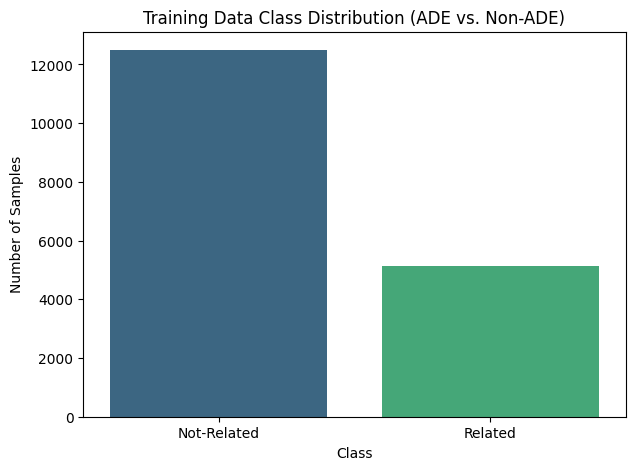

/tmp/ipython-input-5-3135614724.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_class_counts.index, y=test_class_counts.values, palette="plasma")


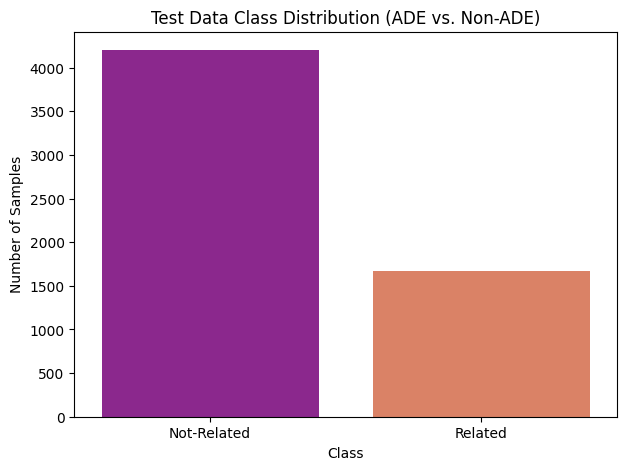

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Hugging Face Datasets to Pandas DataFrames for easier EDA
# initial exploration,
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

print(f"Train dataset size: {len(train_df)} rows")
print(f"Test dataset size: {len(test_df)} rows")

print("\n--- Training Data Class Distribution ---")
train_class_counts = train_df['label_text'].value_counts()
print(train_class_counts)

print("\n--- Test Data Class Distribution ---")
test_class_counts = test_df['label_text'].value_counts()
print(test_class_counts)

# Visualize class distribution for training set
plt.figure(figsize=(7, 5))
sns.barplot(x=train_class_counts.index, y=train_class_counts.values, palette="viridis")
plt.title('Training Data Class Distribution (ADE vs. Non-ADE)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Visualize class distribution for test set
plt.figure(figsize=(7, 5))
sns.barplot(x=test_class_counts.index, y=test_class_counts.values, palette="plasma")
plt.title('Test Data Class Distribution (ADE vs. Non-ADE)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


--- Training Data Sentence Length Statistics (Characters) ---
count    17637.000000
mean       133.354879
std         63.492470
min          7.000000
25%         88.000000
50%        123.000000
75%        168.000000
max        742.000000
Name: text_length, dtype: float64

--- Test Data Sentence Length Statistics (Characters) ---
count    5879.000000
mean      130.894200
std        61.211657
min         8.000000
25%        87.000000
50%       121.000000
75%       165.000000
max       573.000000
Name: text_length, dtype: float64


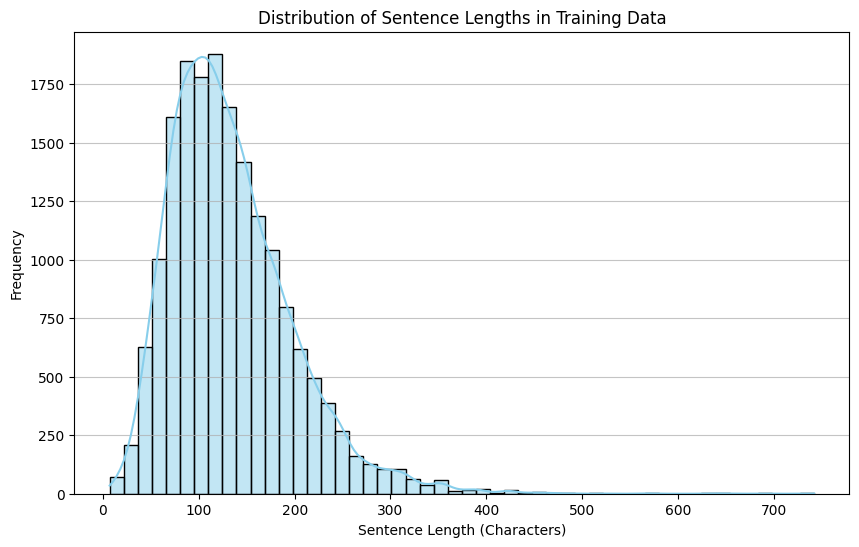

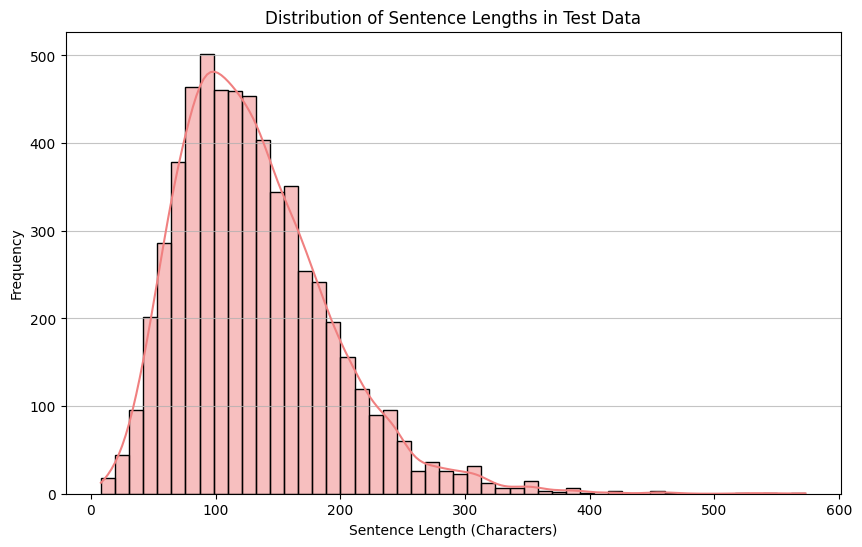

In [6]:
# Calculate sentence lengths
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

print("\n--- Training Data Sentence Length Statistics (Characters) ---")
print(train_df['text_length'].describe())

print("\n--- Test Data Sentence Length Statistics (Characters) ---")
print(test_df['text_length'].describe())

# Visualize sentence length distribution for training set
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.xlabel('Sentence Length (Characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Visualize sentence length distribution for test set
plt.figure(figsize=(10, 6))
sns.histplot(test_df['text_length'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Sentence Lengths in Test Data')
plt.xlabel('Sentence Length (Characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [7]:
import re

def clean_text(text):
    """
    Applies basic text cleaning: lowercasing, removing extra whitespace,
    and removing non-alphanumeric characters (keeping spaces).
    """
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove special characters, keep letters, numbers, spaces
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with single space and strip leading/trailing
    return text

# Apply cleaning to the 'text' column in both train and test dataframes
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print("\n--- Original vs. Cleaned Text Examples (Training Data) ---")
for i in range(5):
    print(f"Original: {train_df['text'].iloc[i]}")
    print(f"Cleaned:  {train_df['cleaned_text'].iloc[i]}\n")

# Store the dataframes back into the dataset object, or simply use train_df/test_df for next phase
# For simplicity, keep working with train_df and test_df for now,
# and convert back to Hugging Face Dataset format when needed

# to update the original 'dataset' object:
# from datasets import Dataset
# dataset['train'] = Dataset.from_pandas(train_df)
# dataset['test'] = Dataset.from_pandas(test_df)


--- Original vs. Cleaned Text Examples (Training Data) ---
Original: On cessation of the injections, the retrocorneal membrane grew rapidly to involve the entire posterior cornea.
Cleaned:  on cessation of the injections the retrocorneal membrane grew rapidly to involve the entire posterior cornea

Original: Median patient age was 52 years.
Cleaned:  median patient age was 52 years

Original: A whole brain irradiation was performed for 37.5Gy with a fraction size of 2.5Gy and gefitinib was replaced with erlotinib on the 5th day after radiation therapy commenced for disease progressing.
Cleaned:  a whole brain irradiation was performed for 375gy with a fraction size of 25gy and gefitinib was replaced with erlotinib on the 5th day after radiation therapy commenced for disease progressing

Original: Complex biochemical syndrome of hypocalcemia and hypoparathyroidism during cytotoxic treatment of an infant with leukemia.
Cleaned:  complex biochemical syndrome of hypocalcemia and hypoparat

2. Baseline Model Development (ML & Feature Engineering)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer - counts the occurrences of each word
# max_features limits the number of unique words (vocabulary size) to consider,
# which can help manage memory and focus on most frequent words.
# min_df ignores words that appear in too few documents (e.g., typos, very rare words)
# max_df ignores words that appear in too many documents (e.g., common words that aren't stop words)
count_vectorizer = CountVectorizer(max_features=5000, min_df=5, max_df=0.9)

# fit the vectorizer on the training data's cleaned text and transform both train and test data
X_train_bow = count_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_bow = count_vectorizer.transform(test_df['cleaned_text'])

# get labels (target variable)
y_train = train_df['label']
y_test = test_df['label']

print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}")
print(f"Vocabulary size: {len(count_vectorizer.vocabulary_)}")

Shape of X_train_bow: (17637, 5000)
Shape of X_test_bow: (5879, 5000)
Vocabulary size: 5000



--- Logistic Regression (Bag-of-Words) Performance ---

Classification Report:
              precision    recall  f1-score   support

 Not-Related       0.93      0.88      0.90      4203
     Related       0.73      0.85      0.78      1676

    accuracy                           0.87      5879
   macro avg       0.83      0.86      0.84      5879
weighted avg       0.88      0.87      0.87      5879



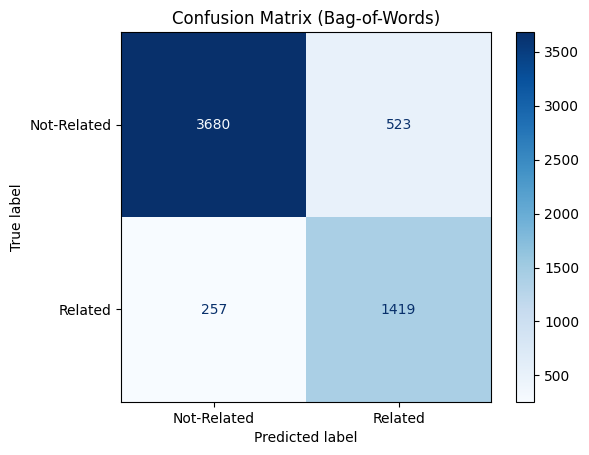


Raw Confusion Matrix:
 [[3680  523]
 [ 257 1419]]


In [10]:
# Logistic Regression model, with CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize Logistic Regression model
# max_iter increased to ensure convergence for larger datasets
# solver='liblinear' good for smaller datasets and L1/L2 regularization
# class_weight='balanced' CRUCIAL here because of our class imbalance.
# It automatically adjusts weights inversely proportional to class frequencies.
log_reg_model_bow = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, class_weight='balanced')

# Train the model
log_reg_model_bow.fit(X_train_bow, y_train)

# Make predictions on the test set
y_pred_bow = log_reg_model_bow.predict(X_test_bow)

print("\n--- Logistic Regression (Bag-of-Words) Performance ---")

# Classification Report
# This provides Precision, Recall, F1-score, and Support for each class.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bow, target_names=['Not-Related', 'Related']))

# Confusion Matrix
cm_bow = confusion_matrix(y_test, y_pred_bow, labels=log_reg_model_bow.classes_)
disp_bow = ConfusionMatrixDisplay(confusion_matrix=cm_bow, display_labels=['Not-Related', 'Related'])
disp_bow.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Bag-of-Words)')
plt.show()

# raw confusion matrix
print("\nRaw Confusion Matrix:\n", cm_bow)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer - Term Frequency-Inverse Document Frequency is
# another common technique. It not only counts word occurrences but also gives
# more weight to words that are rare across the entire corpus but frequent in a
# specific document, it helps highlight words that are more distinctive.
# Same parameters as CountVectorizer for consistency
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9)

# Fit & transform training data, transform test data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")

Shape of X_train_tfidf: (17637, 5000)
Shape of X_test_tfidf: (5879, 5000)



--- Logistic Regression (TF-IDF) Performance ---

Classification Report:
              precision    recall  f1-score   support

 Not-Related       0.93      0.85      0.89      4203
     Related       0.70      0.84      0.76      1676

    accuracy                           0.85      5879
   macro avg       0.81      0.85      0.83      5879
weighted avg       0.86      0.85      0.85      5879



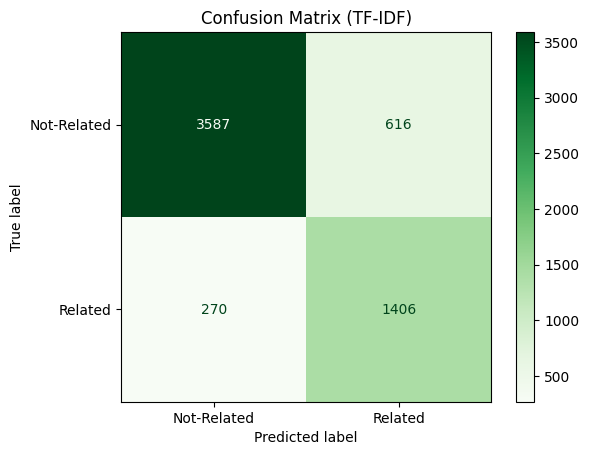


Raw Confusion Matrix:
 [[3587  616]
 [ 270 1406]]


In [12]:
# Logistic Regression model, using TF-IDF features.

# Initialize Logistic Regression model with class_weight='balanced'
log_reg_model_tfidf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, class_weight='balanced')

# Train the model
log_reg_model_tfidf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_tfidf = log_reg_model_tfidf.predict(X_test_tfidf)

print("\n--- Logistic Regression (TF-IDF) Performance ---")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf, target_names=['Not-Related', 'Related']))

# Confusion Matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=log_reg_model_tfidf.classes_)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['Not-Related', 'Related'])
disp_tfidf.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix (TF-IDF)')
plt.show()

print("\nRaw Confusion Matrix:\n", cm_tfidf)